Trần Hoàng Anh 19521215 Link Github: https://github.com/HAnh2610/MKTG5883.N21.CTTT

## Moving beyond Static Visualizations

### 1. Create a dataset of cumulative questions per library over time

In [3]:
import pandas as pd

questions_per_library = pd.read_csv('./DataSet/Lab5/stackoverflow.zip', parse_dates=True, index_col='creation_date').loc[:,'pandas':'bokeh'].resample('1M').sum().cumsum().reindex(pd.date_range('2008-08', '2021-10', freq='M')).fillna(0)
questions_per_library.tail()

pandas  matplotlib    numpy  seaborn  geopandas  geoviews  \
2021-05-31  200734.0     57853.0  89812.0   6855.0     1456.0      57.0   
2021-06-30  205065.0     58602.0  91026.0   7021.0     1522.0      57.0   
2021-07-31  209235.0     59428.0  92254.0   7174.0     1579.0      62.0   
2021-08-31  213410.0     60250.0  93349.0   7344.0     1631.0      62.0   
2021-09-30  214919.0     60554.0  93797.0   7414.0     1652.0      63.0   

            altair  yellowbrick   vega  holoviews  hvplot   bokeh  
2021-05-31   716.0         46.0  532.0      513.0    84.0  4270.0  
2021-06-30   760.0         48.0  557.0      521.0    88.0  4308.0  
2021-07-31   781.0         50.0  572.0      528.0    89.0  4341.0  
2021-08-31   797.0         52.0  589.0      541.0    92.0  4372.0  
2021-09-30   804.0         54.0  598.0      542.0    92.0  4386.0

### 2. Import the FuncAnimation class

In [4]:
from matplotlib.animation import FuncAnimation

### 3. Write a function for generating the initial plot

In [6]:
import matplotlib.pyplot as plt
from matplotlib import ticker

def bar_plot(data):
    fig, ax = plt.subplots(figsize=(8,6))
    sort_order = data.last('1M').squeeze().sort_values().index
    bars = [
        bar.set_label(label) for label, bar in
        zip(sort_order, ax.barh(sort_order, [0] * data.shape[1]))
    ]
    
    ax.set_xlabel('total questions', fontweight='bold')
    ax.set_xlim(0, 250_000)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    fig.tight_layout()
    
    return fig, ax

(<Figure size 800x600 with 1 Axes>, <Axes: xlabel='total questions'>)

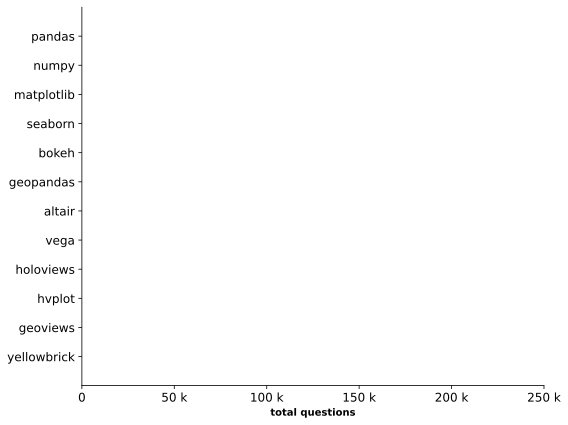

In [7]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
bar_plot(questions_per_library)

### 4. Write a function for generating annotations and plot text

In [8]:
def generate_plot_text(ax):
    annotations = [
        ax.annotate(
            '', xy=(0, bar.get_y() + bar.get_height()/2),
            ha='left', va='center'
        ) for bar in ax.patches
    ]
    
    time_text = ax.text(
        0.9, 0.1, '', transform=ax.transAxes,
        fontsize=15, ha='center', va='center'
    )
    return annotations, time_text

### 5. Define the plot update function

In [9]:
def update(frame, *, ax, df, annotations, time_text):
    data = df.loc[frame, :]
    
    #update bars
    for rect, text in zip(ax.patches, annotations):
        col = rect.get_label()
        if data[col]:
            rect.set_width(data[col])
            text.set_x(data[col])
            text.set_text(f' {data[col]:,.0f}')
            
    #update time
    time_text.set_text(frame.strftime('%b\n%Y'))

### 6. Bind arguments to the update function

In [10]:
from functools import partial

def bar_plot_init(questions_per_library):
    fig, ax = bar_plot(questions_per_library)
    annotations, time_text = generate_plot_text(ax)
    
    bar_plot_update = partial(
        update, ax=ax, df=questions_per_library,
        annotations=annotations, time_text=time_text
    )
    
    return fig, bar_plot_update

### 7. Animate the plot

In [11]:
fig, update_func = bar_plot_init(questions_per_library)

ani = FuncAnimation(
    fig, update_func, frames=questions_per_library.index, repeat=False
)

ani.save(
    './stackoverflow_questions.gif',
    writer='ffmpeg', fps=10, bitrate=100, dpi=300
)
plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.



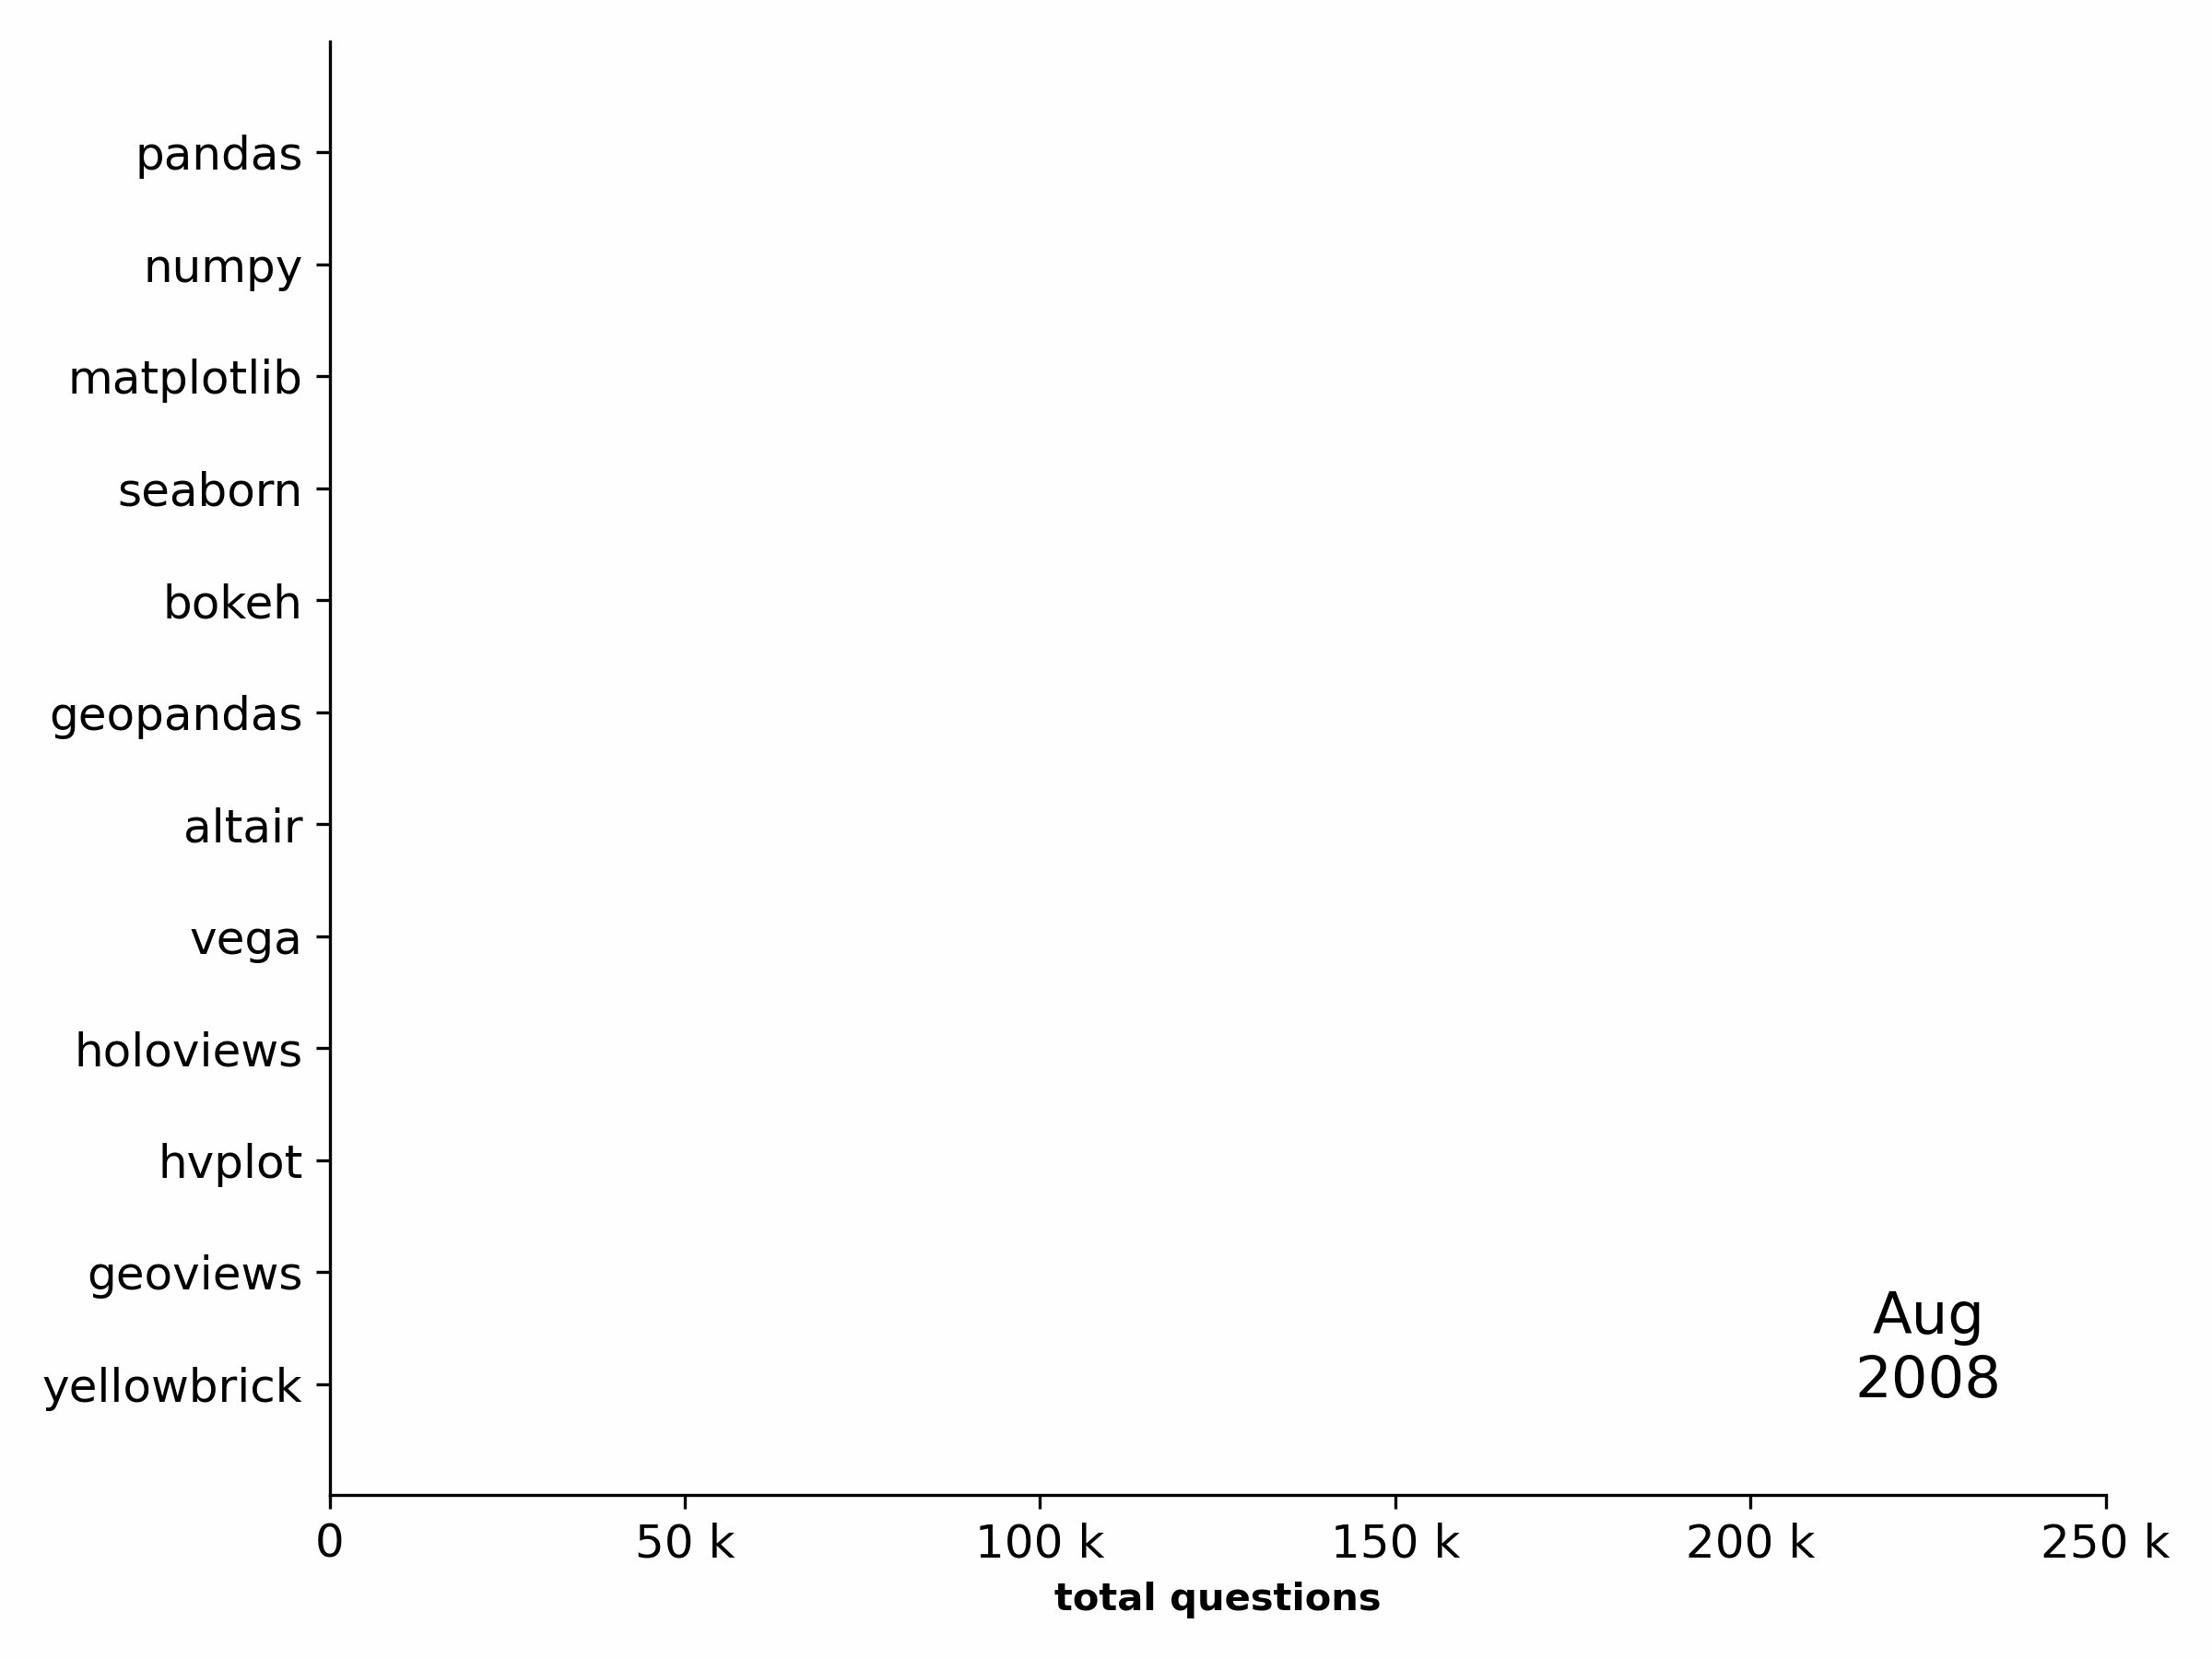

In [12]:
from IPython import display

display.Video(
    './stackoverflow_questions.gif', width=600, height=400,
    embed=True, html_attributes='controls muted autoplay'
)

## Animating distributions over time

### 1. Create a dataset of daily subway entries

In [13]:
subway = pd.read_csv(
    './data/NYC_subway_daily.csv', parse_dates=['Datetime'],
    index_col=['Borough', 'Datetime']
)
subway_daily=subway.unstack(0)
subway_daily.head()

FileNotFoundError: [Errno 2] No such file or directory: './data/NYC_subway_daily.csv'

In [ ]:
manhattan_entries = subway_daily['Entries']['M']

### 2. Determine the bin ranges for the histograms

In [ ]:
import numpy as np

count_per_bin, bin_ranges = np.histogram(manhattan_entries, bins=30)

### 3. Write a function for generating the initial histogram subplots

In [ ]:
def subway_histogram(data, bins, date_range):
    _, bin_ranges = np.histogram(data, bins=bins)
    
    weekday_mask = data.index.weekday < 5
    configs = [
        {'label': 'Weekend', 'mask': ~weekday_mask, 'ymax': 60},
        {'label': 'Weekday', 'mask': weekday_mask, 'ymax': 120}
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
    for ax, config in zip(axes, configs):
        _, _, config['hist'] = ax.hist(
            data[config['mask']].loc[date_range], bin_ranges, ec='black'
        )
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        ax.set(
            xlim=(0, None), ylim=(0, config['ymax']),
        )
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
            
    axes[0].set_ylabel('Frequency')
    fig.suptitle('Histogram of Daily Subway Entries in Manhattan')
    fig.tight_layout()
    
    return fig, axes, bin_ranges, configs

In [ ]:
_ = subway_histogram(manhattan_entries, bins=30, date_range='2017')

### 4. Write a function for generating an annotation for the time period.

In [ ]:
def add_time_text(ax):
    time_text = ax.text(
        0.15, 0.9, '', transform=ax.transAxes,
        fontsize=15, ha='center', va='center'
    )
    return time_text

### 5. Define the plot update function

In [ ]:
def update(frame, *, data, configs, time_text, bin_ranges):
    artists = []
    
    time = frame.strftime('%b\n%Y')
    if time != time_text.get_text():
        time_text.set_text(time)
        artists.append(time_text)
        
    for config in configs:
        time_frame_mask = \
            (data.index > frame - pd.Timedelta(days=365)) & (data.index <= frame)
        counts, _=np.histogram(
            data[time_frame_mask & config['mask']],
            bin_ranges
        )
        for count, rect in zip(counts, config['hist'].patches):
            if count != rect.get_height():
                rect.set_height(count)
                artists.append(rect)
    return artists

### 6. Bind arguments for the update function

In [ ]:
def histogram_init(data, bins, initial_date_range):
    fig, axes, bin_ranges, configs = subway_histogram(data, bins, initial_date_range)
    
    update_func = partial(
        update, data=data, configs=configs,
        time_text=add_time_text(axes[0]),
        bin_ranges=bin_ranges
    )
    return fig, update_func

### 7. Animate the plot

In [ ]:
fig, update_func = histogram_init(
    manhattan_entries, bins=30, initial_date_range=slice('2017', '2019-07')
)

ani = FuncAnimation(
    fig, update_func, frames=manhattan_entries['2019-08':'2021'].index,
    repeat=False, blit=True
)
ani.save(
    './subway_entries_subplots.gif',
    writer='ffmpeg', fps=30, bitrate=500, dpi=300
)
plt.close()

In [ ]:
from IPython import display

display.Video(
    './subway_entries_subplots.gif', width=600, height=400,
    embed=True, html_attributes='controls muted autoplay'
)

## Animating geospatial data with HoloViz

### 1. Use GeoPandas to read in our data

In [ ]:
import geopandas as gpd

earthquakes = gpd.read_file('./data/earthquakes.geojson').assign(
    time=lambda x: pd.to_datetime(x.time, unit='ms'),
    month=lambda x: x.time.dt.month
)[['geometry', 'mag', 'time', 'month']]

earthquakes.shape

In [ ]:
earthquakes.head()

### 2. Handle HoloViz imports and set up the Matplotlin backend

In [ ]:
!pip install pykdtree

In [ ]:
import geoviews as gv
import geoviews.feature as gf
import holoviews as hv

gv.extension('matplotlib')

### 3. Define a function for plotting earthquakes on a map using GeoViews

In [ ]:
import calendar

def plot_earthquakes(data, month_num):
    points = gv.Points(
        data.query(f'month == {month_num}'),
        kdims=['longitude', 'latitude'], #key dimensions (for coordinates in this case)
        vdims=['mag'] # value dimensions (for modifying the plot in this case)
    ).redim.range(mag=(-2, 10), latitude=(-90, 90))
    
    #create an overlay by combining Cartopy features and the points with *
    overlay = gf.land * gf.coastline * gf.borders * points
    
    return overlay.opts(
        gv.opts.Points(color='mag', cmap='fire_r', colorbar=True, alpha=0.75),
        gv.opts.Overlay(
            global_extent=False, title=f'{calendar.month_name[month_num]}', fontscale=2
        )
    )

In [ ]:
plot_earthquakes(earthquakes, 1).opts(
    fig_inches=(6, 3), aspect=2, fig_size=250, fig_bounds=(0.07, 0.05, 0.87, 0.95)
)

### 4. Create a mapping of frames to plots using HoloViews

In [ ]:
frames = {
    month_num: plot_earthquakes(earthquakes, month_num)
    for month_num in range(1, 13)
}
holomap = hv.HoloMap(frames)

### 5. Animate the plot

In [ ]:
hv.output(
    holomap.opts(
        fig_inches=(6, 3), aspect=2, fig_size=250,
        fig_bounds=(0.07, 0.05, 0.87, 0.95)
    ), holomap='gif', fps=5
)

In [ ]:
hv.output(
    holomap.opts(
        fig_inches=(6, 3), aspect=2, fig_size=250,
        fig_bounds=(0.07, 0.05, 0.87, 0.95)
    ), 'earthquakes.gif', fps=5
)

## Up Next: Building Interactive Visualizations for Data Exploration

### Exercises

#### 1. Modify the animation of subway entries from this section to show both the weekday and weekend histograms on the same subplot

In [ ]:
def subway_histogram(data, bins, date_range):
    _, bin_ranges = np.histogram(data, bins=bins)
    
    weekday_mask = data.index.weekday < 5
    configs = [
        {'label': 'Weekend', 'mask': ~weekday_mask, 'ymax': 60},
        {'label': 'Weekday', 'mask': weekday_mask, 'ymax': 120}
    ]
    
    fig, axes = plt.subplots()
    for ax, config in zip(axes, configs):
        _, _, config['hist'] = ax.hist(
            data[config['mask']].loc[date_range], bin_ranges, ec='black'
        )
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        ax.set(
            xlim=(0, None), ylim=(0, config['ymax']),
        )
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)
            
    axes[0].set_ylabel('Frequency')
    fig.suptitle('Histogram of Daily Subway Entries in Manhattan')
    fig.tight_layout()
    
    return fig, axes, bin_ranges, configs

In [ ]:
fig, ax = plt.subplots()

weekday_mask = manhattan_entries.index.weekday < 5

ax.hist(weekday_mask, bins=30, alpha=0.5, label='Weekday')

# Adding labels and title
ax.set_xlabel('Entries')
ax.set_ylabel('Frequency')
ax.set_title('Weekday and Weekend Histograms')

# Adding legend
ax.legend()

# Displaying the plot
plt.show()

#### 2. Modify the earthquake animation to show earthquakes per day in April 2020

## Building Interactive Visualizations for Data Exploration

### 1. Read in and prepare the data

In [ ]:
import geopandas as gpd
import pandas as pd

earthquakes = gpd.read_file('./data/earthquakes.geojson').assign(
    time=lambda x: pd.to_datetime(x.time, unit='ms'),
    month=lambda x: x.time.dt.month
).dropna()

earthquakes.head()

### 2. Import the required libraries and set up the Bokeh backend

In [ ]:
from cartopy import crs
import geoviews as gv
import geoviews.feature as gf

gv.extension('bokeh')

### 3. Create an overlay with tooltips and a slider

In [ ]:
points = gv.Points(
    earthquakes,
    kdims=['longtitude', 'latitude'],
    vdims=['month', 'place', 'tsunami', 'mag', 'magType']
)

#set colorbar limits for magnitude and axis limits
points = points.redim.range(
    mag=(-2, 10), longtitude=(-180, 180), latitude=(-90, 90)
)

In [ ]:
overlay = gf.land * gf.coastline * gf.borders * points.groupby('month')

In [ ]:
interactive_map = overlay.opts(
    gv.opts.Feature(projection=crs.PlateCarree()),
    gv.opts.Overlay(width=700, height=450),
    gv.opts.Points(color='mag', cmap='fire_r', colorbar=True, tools=['hover'])
)

### 4. Render the visualiztion

In [ ]:
import panel as pn
earthquake_viz = pn.panel(interactive_map, widget_location='bottom')

In [ ]:
earthquake_viz.embed()

## Linking plots

### 1. Isolate the January earthquake data and prepare it for plotting

In [ ]:
january_earthquakes = earthquakes.query('month == 1').assign(
    longtitude=lambda x: x.geometry.x,
    latitude=lambda x: x.geometry.y
).drop(columns=['month', 'geometry'])

### 2. Enable the use of hvPlot for interactive plotting with pandas

In [ ]:
import hvplot.pandas

### 3. Build a layout composed of an interactive map and a table with hvPlot

In [ ]:
geo = january_earthquakes.hvplot(
    x='longtitude', y='latitude', kind='points',
    color='mag', cmap='fire_r', clim=(-2, 10),
    titles='CartoLight', geo=True, global_extent=True,
    xlabel='Longtitude', ylabel='Latitude', title='January 2020 Earthquakes',
    frame_height=450
)

In [ ]:
table = january_earthquakes.sort_values(['longtitude', 'latitude']).hvplot(
    kind='table', width=650, height=450, title='Raw Data'
)

In [ ]:
layout = geo + table

### 4. Link selections across the visualization in the layout

In [ ]:
import holoviews as hv

selection = hv.link_selections.instance()
map_and_table_tabs = selection(layout).opts(tabs=True)

In [ ]:
map_and_table_tabs

In [ ]:
selection.filter(january_earthquakes).nlargest(3, 'mag')

## Additional plot types

In [ ]:
import numpy as np

flight_stats = pd.read_csv(
    './data/T100_MARKET_ALL_CARRIER.zip',
    usecols=[
        'CLASS', 'REGION', 'UNIQUE_CARRIER_NAME', 'ORIGIN_CITY_NAME', 'ORIGIN',
        'DEST_CITY_NAME', 'DEST', 'PASSENGERS', 'FREIGHT', 'MAIL'
    ]
).rename(lambda x: x.lower(), axis=1).assign(
    region=lambda x: x.region.replace({
        'D': 'Domestic', 'I': 'International', 'A': 'Atlantic',
        'L': 'Latin America', 'P': 'Pacific', 'S': 'System'
    }),
    route=lambda x: np.where(
        x.origin < x.dest,
        x.origin + '-' + x.dest,
        x.dest + '-' + x.origin
    )
)

In [ ]:
flight_stats.head()

In [ ]:
cities = [
    'Atlanta, GA', 'Chicago, IL', 'New York, NY', 'Los Angeles, CA',
    'Dallas/Fort Worth, TX', 'Denver, CO', 'Houston, TX',
    'San Francisco, CA', 'Seattle, WA', 'Orlando, FL'
]

top_airlines = [
    'American Airlines Inc.', 'Delta Air Lines Inc.', 'JetBlue Airways',\
    'Southwest Airlines Co.', 'United Air Lines Inc,'
]

## Chord diagram

### 1. Aggregate the dataset to get total flight statistics between the top cities

In [ ]:
total_flight_stats = flight_stats.query(
    f'`class` == "F" and origin_city_name != dest_city_name'
    f' and origin_city_name.isin({cities}) and dest_city_name.isin({cities})'
).groupby([
    'origin', 'origin_city_name', 'dest', 'dest_city_name'
])[['passengers', 'freight', 'mail']].sum().reset_index().query('passengers > 0')

In [ ]:
total_flight_stats.sample(10, random_state=1)

### 2. Create a chord diagram with HoloViews

In [ ]:
chord = hv.Chord(
    total_flight_stats,
    kdims=['origin', 'dest'],
    vdims=['passengers', 'origin_city_name', 'dest_city_name', 'mail', 'freight']
)

### 3. Customize the tooltips using Bokeh

In [ ]:
from bokeh.models import HoverTool

tooltips = {
    'Source': '@origin_city_name (@origin)',
    'Target': '@dest_city_name (@dest)',
    'Passengers': '@passengers{0,.}',
    'Mail': '@mail{0,.} lbs.',
    'Freight': '@freight{0,.} lbs.',
}
hover = HoverTool(tooltips=tooltips)

## Sankey plot

### 1. Isolate flight statistics for top routes

In [ ]:
top_cities = cities[:5]

domestic_passenger_travel = flight_stats.query(
    'region == "Domestics" and `class` == "F" and origin_city_name != dest_city_name '
    f'and origin_city_name.isin({top_cities}) and dest_city_name.isin({top_cities})'
).groupby([
    'region', 'unique_carrier_name', 'route',
    'origin_city_name', 'dest_city_name'
]).passengers.sum().reset_index()

domestic_passenger_travel.head()

### 2. Convert the data into a set of edges

In [ ]:
domestic_passenger_travel.unique_carrier_name.replace(
    '^(?!' + '|'.join(top_airlines) + ').*S',
    'Other Airlines',
    regex=True, inplace=True
)

In [ ]:
domestic_passenger_travel.groupby('unique_carrier_name').passengers.sum().div(
    domestic_passenger_travel.passengers.sum()
)

In [ ]:
def get_edges(data, *, source_col, target_col):
    aggregated = data.groupby([source_col, target_col]).passengers.sum()
    re

In [ ]:
carrier_edges = get_edges(
    domestic_passenger_travel,
    source_col='region',
    target_col='unique_carrier_name'
).replace('Domestic', 'Top Routes')

carrier_edges

In [ ]:
carrier_to_route_edges = get_edges(
    domestic_passenger_travel,
    source_col='unique_carrier_name',
    target_col='route'
)

carrier_to_route_edges.sample(10, random_state=1)

### 4. Create the Sankey plot with HoloViews

In [ ]:
sankey = hv.Sankey(
    all_edges,
    kdims=['source', 'target'],
    vdims=hv.Dimension('passengers', unit='M')
).opts(
    labels='index', label_position='right', cmap='Set1', # node config
    edge_color='lightgray', # edge config
    width=750, height=600, # plot size config
    title='Travel Between the Top 5 Cities in 2019'
)

In [ ]:
sankey

## Exercises

### 1. For the 10 carriers that transported the most freight, create a bar plot showing total freight transported per carrier

### 2. Create a line plot of total earthquakes per day with tooltips

### 3. Make histograms of earthquake magnitude (mag) for each magnitude type (magType) with a dropdown to select the magnitude type